In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

# plot inline
%matplotlib inline


In [2]:
# global variables

start_date = "2006-11-01"
end_date   = "2025-11-13"  # end is *exclusive*, so this covers up to 2025-11-12
starting_capital = 100_000.0

In [3]:
spy =\
(
    yf.
    download(
        "^GSPC",
        start = start_date,
        end = end_date
    )
)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
spy.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000


In [5]:
spy.isnull().sum()

Price   Ticker
Close   ^GSPC     0
High    ^GSPC     0
Low     ^GSPC     0
Open    ^GSPC     0
Volume  ^GSPC     0
dtype: int64

In [6]:
return_df =\
(
    spy
    ['Close']
    .rename(columns={'^GSPC': "Close"})
)

return_df


Ticker,Close
Date,
2006-11-01,1367.810059
2006-11-02,1367.339966
2006-11-03,1364.300049
2006-11-06,1379.780029
2006-11-07,1382.839966
...,...
2025-11-06,6720.319824
2025-11-07,6728.799805
2025-11-10,6832.430176


# Momentum Strategy

In [22]:
## we define the short and long MAs for our momentum strategy

# these are arbitrary 
short = 20
long = 80

In [8]:
short_long_periods = [10, 20, 50, 80, 100, 150, 200]

### Create empty signals DF

In [9]:
buy_or_sell = pd.DataFrame(index = return_df.index)
buy_or_sell.head()

""
Date
2006-11-01
2006-11-02
2006-11-03
2006-11-06
2006-11-07


In [10]:
buy_or_sell["Signal"] = 0
buy_or_sell.head()

,Signal
Date,
2006-11-01,0
2006-11-02,0
2006-11-03,0
2006-11-06,0
2006-11-07,0


In [11]:
buy_or_sell['short_ma'] = return_df['Close'].rolling(window=short, min_periods=1,center=False).mean()

In [12]:
buy_or_sell

,Signal,short_ma
Date,,
2006-11-01,0,1367.810059
2006-11-02,0,1367.575012
2006-11-03,0,1366.483358
2006-11-06,0,1369.807526
2006-11-07,0,1372.414014
...,...,...
2025-11-06,0,6748.749976
2025-11-07,0,6757.564478
2025-11-10,0,6766.449976


In [13]:
buy_or_sell['long_ma'] = return_df['Close'].rolling(window=long, min_periods=1,center=False).mean()
buy_or_sell.head()

,Signal,short_ma,long_ma
Date,,,
2006-11-01,0,1367.810059,1367.810059
2006-11-02,0,1367.575012,1367.575012
2006-11-03,0,1366.483358,1366.483358
2006-11-06,0,1369.807526,1369.807526
2006-11-07,0,1372.414014,1372.414014


## Create signal when short ma crosses the long ma

In [17]:
buy_or_sell['Signal'][long:]= \
(
    np.where(buy_or_sell['short_ma'][long:]
    > buy_or_sell['long_ma'][long:], 1, 0
    )
)

buy_or_sell.head()


,Signal,short_ma,long_ma
Date,,,
2006-11-01,0,1367.810059,1367.810059
2006-11-02,0,1367.575012,1367.575012
2006-11-03,0,1366.483358,1366.483358
2006-11-06,0,1369.807526,1369.807526
2006-11-07,0,1372.414014,1372.414014


In [19]:
buy_or_sell.columns


Index(['Signal', 'short_ma', 'long_ma'], dtype='object')

In [20]:
buy_or_sell['positions'] = buy_or_sell['Signal'].diff()
buy_or_sell.head()

,Signal,short_ma,long_ma,positions
Date,,,,
2006-11-01,0,1367.810059,1367.810059,NaN
2006-11-02,0,1367.575012,1367.575012,0.0
2006-11-03,0,1366.483358,1366.483358,0.0
2006-11-06,0,1369.807526,1369.807526,0.0
2006-11-07,0,1372.414014,1372.414014,0.0


## Plot of our entries

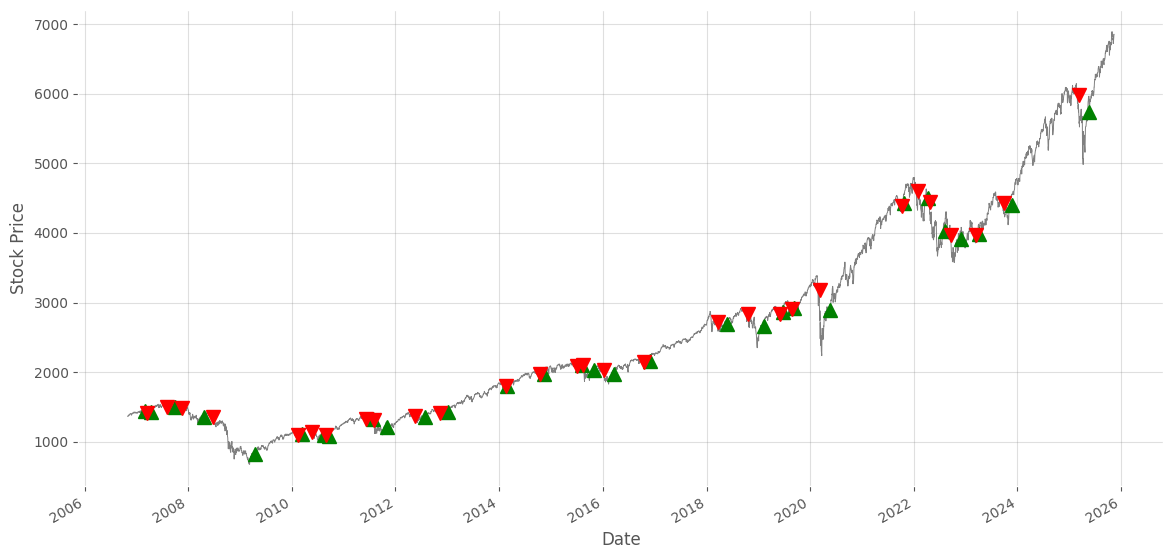

In [21]:
f = \
(
    plt.figure(figsize=(14, 7))
)

sub = \
(
    f.add_subplot(111, ylabel ='Stock Price')
)

(
    return_df['Close'].plot(ax = sub, lw = 0.7,color = 'grey')
)

# buy signal
(
    sub.plot(
        buy_or_sell.loc[buy_or_sell.positions == 1.0].index,
        buy_or_sell.short_ma[buy_or_sell.positions == 1.0],"^",
        markersize = 10, color = 'g', label = 'buy'
    )
)

# sell signal
(
    sub.plot(
        buy_or_sell.loc[buy_or_sell.positions == -1.0].index,
        buy_or_sell.short_ma[buy_or_sell.positions == -1.0],"v",
        markersize = 10, color = 'r', label = 'sell'
    )
)



In [24]:
%whos

Variable             Type         Data/Info
-------------------------------------------
buy_or_sell          DataFrame                Signal     sh<...>\n[4788 rows x 4 columns]
dt                   module       <module 'datetime' from '<...>on313\\Lib\\datetime.py'>
end_date             str          2025-11-13
f                    Figure       Figure(1400x700)
long                 int          80
mpl                  module       <module 'matplotlib' from<...>matplotlib\\__init__.py'>
np                   module       <module 'numpy' from 'c:\<...>ges\\numpy\\__init__.py'>
pd                   module       <module 'pandas' from 'c:<...>es\\pandas\\__init__.py'>
pdr                  module       <module 'pandas_datareade<...>das_datareader\\data.py'>
plt                  module       <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
return_df            DataFrame    Ticker            Close\n<...>\n[4788 rows x 1 columns]
short                int          20
short_long_periods   l

In [25]:
our_position = \
(
    pd.DataFrame(index = buy_or_sell.index)
)

our_position.head()


""
Date
2006-11-01
2006-11-02
2006-11-03
2006-11-06
2006-11-07


In [28]:
return_df.head().mean()


Ticker
Close    1372.414014
dtype: float64

In [38]:
our_position['spy'] = \
(
    buy_or_sell['Signal'].shift(1) * 8 # we buy 8 shares
)
our_position.tail()

,spy
Date,
2025-11-06,8.0
2025-11-07,8.0
2025-11-10,8.0
2025-11-11,8.0
2025-11-12,8.0


In [39]:
portfolio = \
(
    our_position.multiply(return_df['Close'], axis = 0)
)

In [40]:
portfolio

,spy
Date,
2006-11-01,NaN
2006-11-02,0.000000
2006-11-03,0.000000
2006-11-06,0.000000
2006-11-07,0.000000
...,...
2025-11-06,53762.558594
2025-11-07,53830.398438
2025-11-10,54659.441406


In [41]:
difference_in_shares_owned = \
(
    our_position.diff()
)

difference_in_shares_owned.head()

,spy
Date,
2006-11-01,NaN
2006-11-02,NaN
2006-11-03,0.0
2006-11-06,0.0
2006-11-07,0.0


In [42]:
portfolio['holdings'] = \
(
    our_position.multiply(return_df['Close'], axis = 0).sum(axis=1)
)

portfolio

,spy,holdings
Date,,
2006-11-01,NaN,0.000000
2006-11-02,0.000000,0.000000
2006-11-03,0.000000,0.000000
2006-11-06,0.000000,0.000000
2006-11-07,0.000000,0.000000
...,...,...
2025-11-06,53762.558594,53762.558594
2025-11-07,53830.398438,53830.398438
2025-11-10,54659.441406,54659.441406


In [43]:
portfolio['our_cash'] = \
(
    starting_capital - (difference_in_shares_owned.multiply(return_df['Close'], axis = 0).sum(axis=1)).cumsum()
)

portfolio

,spy,holdings,our_cash
Date,,,
2006-11-01,NaN,0.000000,100000.000000
2006-11-02,0.000000,0.000000,100000.000000
2006-11-03,0.000000,0.000000,100000.000000
2006-11-06,0.000000,0.000000,100000.000000
2006-11-07,0.000000,0.000000,100000.000000
...,...,...,...
2025-11-06,53762.558594,53762.558594,71925.119629
2025-11-07,53830.398438,53830.398438,71925.119629
2025-11-10,54659.441406,54659.441406,71925.119629


In [44]:
portfolio['total'] = \
(
    portfolio['our_cash'] + portfolio['holdings']
)

portfolio

,spy,holdings,our_cash,total
Date,,,,
2006-11-01,NaN,0.000000,100000.000000,100000.000000
2006-11-02,0.000000,0.000000,100000.000000,100000.000000
2006-11-03,0.000000,0.000000,100000.000000,100000.000000
2006-11-06,0.000000,0.000000,100000.000000,100000.000000
2006-11-07,0.000000,0.000000,100000.000000,100000.000000
...,...,...,...,...
2025-11-06,53762.558594,53762.558594,71925.119629,125687.678223
2025-11-07,53830.398438,53830.398438,71925.119629,125755.518066
2025-11-10,54659.441406,54659.441406,71925.119629,126584.561035


In [45]:
portfolio['returns'] = \
(
    portfolio['total'].pct_change()
)
portfolio

,spy,holdings,our_cash,total,returns
Date,,,,,
2006-11-01,NaN,0.000000,100000.000000,100000.000000,NaN
2006-11-02,0.000000,0.000000,100000.000000,100000.000000,0.000000
2006-11-03,0.000000,0.000000,100000.000000,100000.000000,0.000000
2006-11-06,0.000000,0.000000,100000.000000,100000.000000,0.000000
2006-11-07,0.000000,0.000000,100000.000000,100000.000000,0.000000
...,...,...,...,...,...
2025-11-06,53762.558594,53762.558594,71925.119629,125687.678223,-0.004812
2025-11-07,53830.398438,53830.398438,71925.119629,125755.518066,0.000540
2025-11-10,54659.441406,54659.441406,71925.119629,126584.561035,0.006592


## Visualize

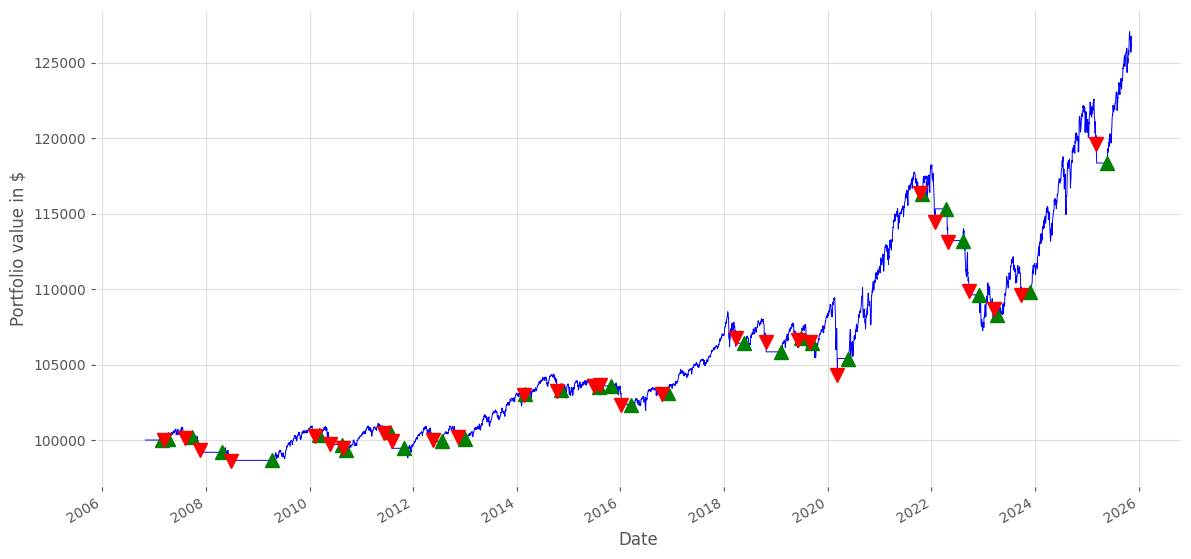

In [46]:
f = \
(
      plt.figure(figsize=(14, 7))   
)

ax = \
(
    f.add_subplot(111, ylabel = 'Portfolio value in $')
)

(
    portfolio['total'].plot(ax = ax, lw = 0.7, color = 'blue', label = 'Portfolio value')
)

(
    ax.plot(portfolio.loc[buy_or_sell.positions == 1.0].index,
            portfolio['total'][buy_or_sell.positions == 1.0],"^", color='g', markersize=10)
)

(
    ax.plot(portfolio.loc[buy_or_sell.positions == -1.0].index,
            portfolio['total'][buy_or_sell.positions == -1.0],"v", color='r', markersize=10)
)




## Performance 

In [47]:
from lets_plot import *
LetsPlot.setup_html()

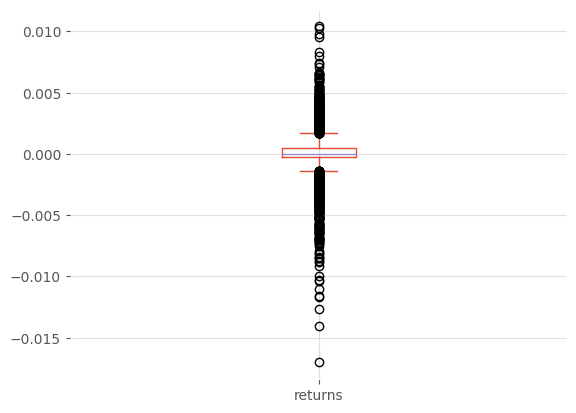

In [49]:
portfolio['returns'].plot(kind = 'box')
plt.show()

In [50]:
annualized_vol = \
(
    portfolio['returns'].std() * np.sqrt(252)
)

In [53]:
sharpe = \
(
    (portfolio['returns'].mean() / portfolio['returns'].std()) * np.sqrt(252)
)

print(f"The Sharpe of the momentum strategy is {sharpe:.2f}")

The Sharpe of the momentum strategy is 0.49


<Axes: xlabel='Date'>

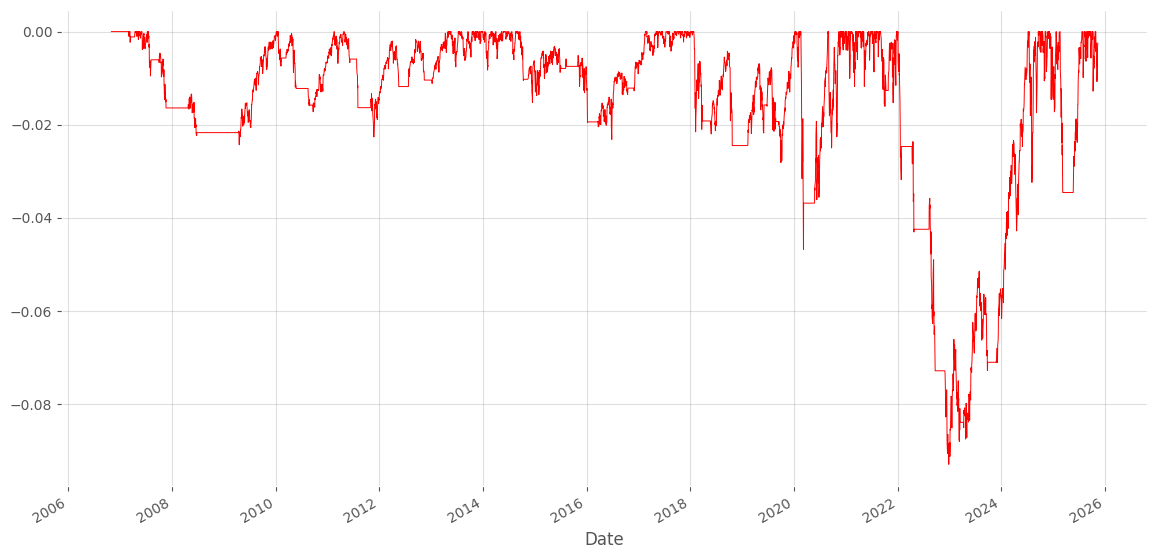

In [54]:
daily_drawdown = \
(
    portfolio['total'] / portfolio['total'].cummax() - 1.0
)
daily_drawdown.plot(figsize = (14, 7), color = 'red', lw = 0.7)

In [61]:
daily_drawdown

Date
2006-11-01    0.000000
2006-11-02    0.000000
2006-11-03    0.000000
2006-11-06    0.000000
2006-11-07    0.000000
                ...   
2025-11-06   -0.010740
2025-11-07   -0.010206
2025-11-10   -0.003681
2025-11-11   -0.002788
2025-11-12   -0.002517
Name: total, Length: 4788, dtype: float64

In [62]:
window = 252

In [63]:
max_daily_drawdown = \
(
    daily_drawdown.rolling(window=window, min_periods=1,center=False).min()
)

In [65]:
max_daily_drawdown.min()

np.float64(-0.09293767112904916)

In [66]:
print(f"the maximum drawdown over a rolling 252-day window is {max_daily_drawdown.min():.2%}    ")

the maximum drawdown over a rolling 252-day window is -9.29%    


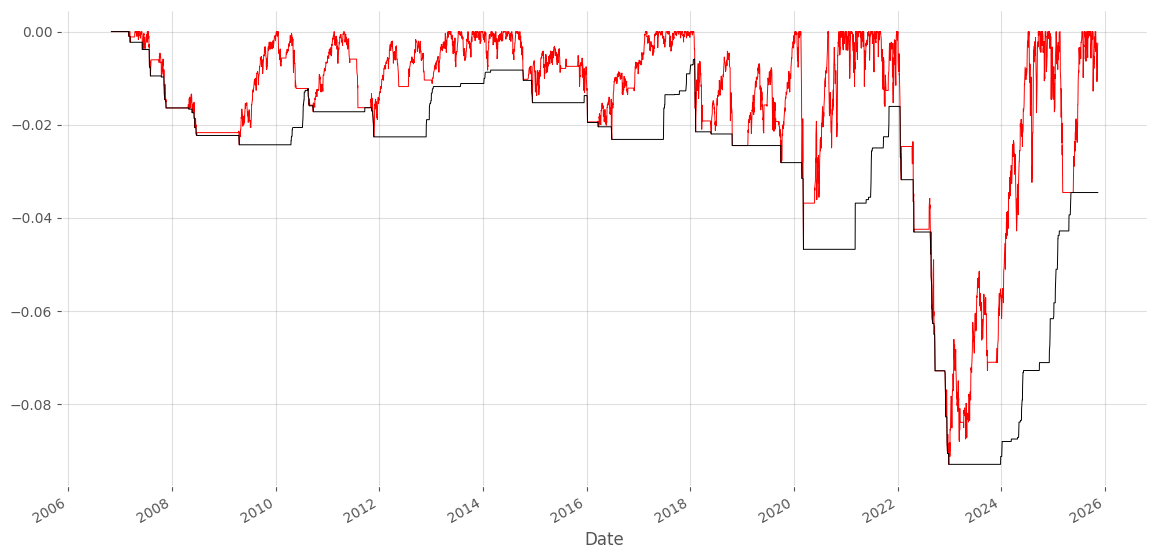

In [64]:
fig = plt.figure(figsize=(14,7))
daily_drawdown.plot(color='red', lw=0.7)
max_daily_drawdown.plot(color='black', lw=0.7)

plt.show()

In [72]:
days = \
(
    (return_df.index[-1] - return_df.index[0]).days
)
days

6951

In [68]:
cagr = \
(
    (portfolio['total'][-1] / starting_capital) ** (365.0 / days) - 1.0 
)

print(f"The CAGR of the momentum strategy is {cagr:.2%}    ")

The CAGR of the momentum strategy is 1.25%    


In [69]:
print(f"The sharpe of the momentum strategy is {sharpe:.2f}")
print(f"The CAGR of the momentum strategy is {cagr:.2%}")
print(f"The maximum drawdown over a rolling 252-day window is {max_daily_drawdown.min():.2%}    ")

The sharpe of the momentum strategy is 0.49
The CAGR of the momentum strategy is 1.25%
The maximum drawdown over a rolling 252-day window is -9.29%    


In [70]:
print(f"The end portfolio value is ${portfolio['total'][-1]:.2f}    ")

The end portfolio value is $126732.48    


In [71]:
print(f"The cummulative return of the momentum strategy is {(portfolio['total'][-1] / starting_capital - 1.0):.2%}    ")

The cummulative return of the momentum strategy is 26.73%    


In [ ]:
# Performance Analysis for Last 25% of Timeframe

Analyzing the momentum strategy performance for the most recent quarter of the data period.

In [74]:
# Calculate the last 25% of the data
total_data_points = len(portfolio)
quarter_data_points = int(total_data_points * 0.75)  # Starting point for last 25%

print(f"Total data points: {total_data_points}")
print(f"Last 25% starts at index: {quarter_data_points}")
print(f"Date range for last 25%: {portfolio.index[quarter_data_points]} to {portfolio.index[-1]}")

# Extract the last 25% of the data
portfolio_last_quarter = portfolio.iloc[quarter_data_points:].copy()
print(f"Number of days in last 25%: {len(portfolio_last_quarter)}")

Total data points: 4788
Last 25% starts at index: 3591
Date range for last 25%: 2021-02-09 00:00:00 to 2025-11-12 00:00:00
Number of days in last 25%: 1197


In [75]:
# Calculate performance metrics for the last 25% period
returns_last_quarter = portfolio_last_quarter['returns'].dropna()

# Sharpe Ratio for last 25%
sharpe_last_quarter = (returns_last_quarter.mean() / returns_last_quarter.std()) * np.sqrt(252)

# Annualized Volatility for last 25%
annualized_vol_last_quarter = returns_last_quarter.std() * np.sqrt(252)

print(f"Performance Metrics for Last 25% of Timeframe:")
print(f"Sharpe Ratio: {sharpe_last_quarter:.2f}")
print(f"Annualized Volatility: {annualized_vol_last_quarter:.2%}")

Performance Metrics for Last 25% of Timeframe:
Sharpe Ratio: 0.64
Annualized Volatility: 3.97%


In [81]:
# Calculate CAGR for the last 25% period (normalized to $100,000 starting value)
start_value_quarter_original = portfolio_last_quarter['total'].iloc[0]
end_value_quarter_original = portfolio_last_quarter['total'].iloc[-1]
days_quarter = len(portfolio_last_quarter)

# Normalize to $100,000 starting value
normalization_factor = 100_000.0 / start_value_quarter_original
start_value_quarter = 100_000.0
end_value_quarter = end_value_quarter_original * normalization_factor

cagr_last_quarter = (end_value_quarter / start_value_quarter) ** (365.0 / days_quarter) - 1.0

print(f"CAGR for Last 25% (normalized to $100K start): {cagr_last_quarter:.2%}")
print(f"Starting Portfolio Value: ${start_value_quarter:.2f}")
print(f"Ending Portfolio Value: ${end_value_quarter:.2f}")
print(f"Total Return for Last 25%: {(end_value_quarter / start_value_quarter - 1.0):.2%}")
print(f"Original values - Start: ${start_value_quarter_original:.2f}, End: ${end_value_quarter_original:.2f}")

CAGR for Last 25% (normalized to $100K start): 3.63%
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $112395.09
Total Return for Last 25%: 12.40%
Original values - Start: $112756.24, End: $126732.48


In [77]:
# Calculate Maximum Drawdown for the last 25% period
daily_drawdown_quarter = portfolio_last_quarter['total'] / portfolio_last_quarter['total'].cummax() - 1.0
max_drawdown_quarter = daily_drawdown_quarter.min()

print(f"Maximum Drawdown for Last 25%: {max_drawdown_quarter:.2%}")

# Rolling maximum drawdown for last 25% (using smaller window due to shorter period)
window_quarter = min(126, len(portfolio_last_quarter) // 2)  # 6 months or half the period
max_rolling_drawdown_quarter = daily_drawdown_quarter.rolling(window=window_quarter, min_periods=1).min().min()

print(f"Maximum Rolling Drawdown (6-month window): {max_rolling_drawdown_quarter:.2%}")

Maximum Drawdown for Last 25%: -9.29%
Maximum Rolling Drawdown (6-month window): -9.29%


In [ ]:
# Summary comparison: Full period vs Last 25% (normalized to $100K start)
print("="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Metric':<30} {'Full Period':<20} {'Last 25% (Normalized)':<20}")
print("-"*70)
print(f"{'Sharpe Ratio':<30} {sharpe:<20.2f} {sharpe_last_quarter:<20.2f}")
print(f"{'CAGR':<30} {cagr:<20.2%} {cagr_last_quarter:<20.2%}")
print(f"{'Annualized Volatility':<30} {annualized_vol:<20.2%} {annualized_vol_last_quarter:<20.2%}")
print(f"{'Max Drawdown':<30} {max_daily_drawdown.min():<20.2%} {max_drawdown_quarter:<20.2%}")
print(f"{'Total Return':<30} {(portfolio['total'][-1] / starting_capital - 1.0):<20.2%} {(end_value_quarter / start_value_quarter - 1.0):<20.2%}")
print(f"{'Starting Value':<30} ${'100,000.00':<19} ${'100,000.00':<19}")
print(f"{'Ending Value':<30} ${portfolio['total'][-1]:<19,.2f} ${end_value_quarter:<19,.2f}")
print("="*70)

PERFORMANCE COMPARISON
Metric                         Full Period     Last 25%       
------------------------------------------------------------
Sharpe Ratio                   0.49            0.64           
CAGR                           1.25%           3.63%          
Annualized Volatility          2.64%           3.97%          
Max Drawdown                   -9.29%          -9.29%         
Total Return                   26.73%          12.40%         


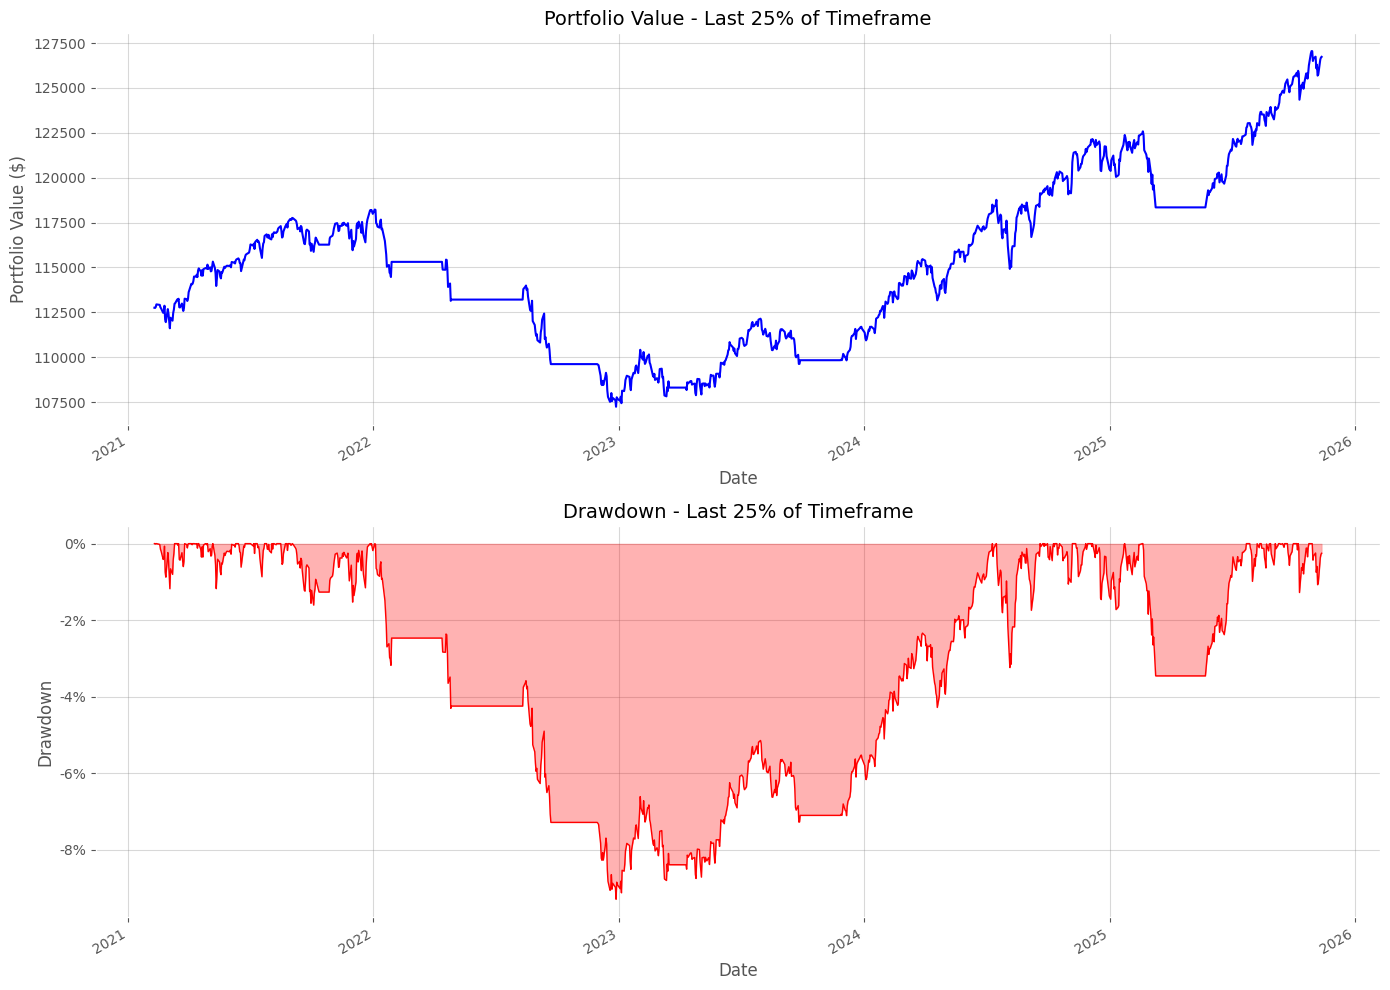

In [79]:
# Visualize the portfolio performance for the last 25% period
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Portfolio value plot
portfolio_last_quarter['total'].plot(ax=ax1, color='blue', linewidth=1.5)
ax1.set_title('Portfolio Value - Last 25% of Timeframe', fontsize=14)
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True, alpha=0.3)

# Drawdown plot
daily_drawdown_quarter.plot(ax=ax2, color='red', linewidth=1)
ax2.fill_between(daily_drawdown_quarter.index, daily_drawdown_quarter, 0, alpha=0.3, color='red')
ax2.set_title('Drawdown - Last 25% of Timeframe', fontsize=14)
ax2.set_ylabel('Drawdown')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()